# Task 2: Clustering

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Customer Profile model

In [21]:
customer_profile = pd.read_csv('../dataset/customer_profile_model.csv', sep='\t', index_col=0)
customer_profile

,I,Iu,Imax,monetary,recency,T,frequency
CustomerID,,,,,,,
12747.0,6.967909,3.663562,5.337538,5.762366,2.079442,5.831882,5.985119
12748.0,10.012656,7.378384,7.396949,5.814429,4.584967,5.828946,5.636840
12749.0,7.293698,5.075174,6.699500,5.746523,1.098612,5.817111,6.595348
12820.0,6.582025,4.007333,5.497168,5.642262,1.098612,5.789960,5.550605
12822.0,6.309918,3.713572,6.049733,2.839078,0.000000,4.477337,5.553270
...,...,...,...,...,...,...,...
18272.0,7.625595,4.595120,6.238325,5.407620,1.609438,5.420535,6.305677
18273.0,4.382027,0.000000,3.688879,4.673763,0.693147,5.552960,4.338597
18282.0,4.634729,2.484907,4.317488,4.443827,0.000000,5.707110,4.608265


In [22]:
customer_profile = customer_profile.to_numpy()

## K-means

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

In [34]:
def silhouette_scorer(pipeline, X):
    pipeline.fit(X)
    cluster_labels = pipeline['kmeans'].labels_
    return silhouette_score(X, cluster_labels)
    
# define a pipeline to search for the best combination of PCA truncation, scaler and the number of kmeans clusters
pipeline = Pipeline(steps=[('pca', PCA()), # a common practice before doing clustering: PCA which calculates the dimensions which best maximize variance; 
                           # it does dimensionality reduction while keeping the most important features, i.e. combinations of features best describe customers.
                           ('scaler', StandardScaler()),
                           ('kmeans', KMeans(init='k-means++'))])

n_features = customer_profile.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    'pca__n_components': range(2, n_features + 1),
    'kmeans__n_clusters': range(2, 10)}
    # 'kmeans__n_init': [100]}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(customer_profile)

Fitting 1 folds for each of 48 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    3.3s finished


In [35]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

def highlight_equal(s, value, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == value
    return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'kmeans__n_clusters': 2, 'pca__n_components': 2}",0.297943,1
"{'kmeans__n_clusters': 2, 'pca__n_components': 3}",0.291906,2
"{'kmeans__n_clusters': 3, 'pca__n_components': 2}",0.268755,3
"{'kmeans__n_clusters': 3, 'pca__n_components': 3}",0.258139,4
"{'kmeans__n_clusters': 2, 'pca__n_components': 5}",0.253291,5
"{'kmeans__n_clusters': 2, 'pca__n_components': 4}",0.250819,6
"{'kmeans__n_clusters': 2, 'pca__n_components': 7}",0.250373,7
"{'kmeans__n_clusters': 4, 'pca__n_components': 3}",0.246678,8
"{'kmeans__n_clusters': 2, 'pca__n_components': 6}",0.237995,9
"{'kmeans__n_clusters': 3, 'pca__n_components': 4}",0.222178,10


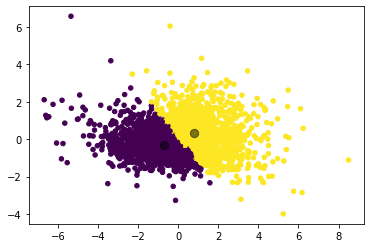

In [36]:
# create a scatter plot
clusters_customers = search.predict(customer_profile)
pca_customer_profile = search.best_estimator_['pca'].transform(customer_profile)
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20)
# select cluster centers
centroids = search.best_estimator_['kmeans'].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

What's the number of customers in each cluster?

In [37]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNumber']).T

,0,1
CustomersNumber,1248,1145


## DBSCAN